<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/30_Light_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_%D0%9F%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов

Используйте готовый ноутбук с занятия.

1.Соберите обучающую и проверочную выборку (просто запуская последовательно ячейки ноутбука).

2.Обучите полносвязную сеть.

3.Сделайте совсем простую сеть: один скрытый слой и 10 нейронов.

4.Сделайте сложную сеть: 5-7 слоёв по 100-1000 нейронов.

5.Добавьте в сеть слои Dropout.

6.Добавьте в сеть слои BatchNormalization.

7.Поменяйте внутренние активационные функции, варианты: relu, elu, linear.

8.Поменяйте размер batch_size: маленький, средний и большой.

Во всех пунктах, где запускали сеть (пункты 2-8), напишите, какую использовали архитектуру, какая была точность на обучающей и проверочной выборках.

Напишите свои выводы.

# Загрузка данных и формирование выборки

In [ ]:
import librosa # Для параметризации аудио
import librosa.display # Для отображения аудиосигнала
import matplotlib.pyplot as plt
from google.colab import files # Для загрузки файлов 
import IPython.display as ipd # Для проигрывания аудио
import os
import numpy as np

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input,  Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Базы/genres.zip'



In [ ]:

genres = os.listdir('genres') # получаем список папок в распакованной папке

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
from librosa.feature.spectral import mfcc
#Функция параметризации аудио
def get_features(y,sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по усолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) # Мел кепстральные коэффициенты (по усолчанию 20)

  rmse = np.mean(librosa.feature.mfcc(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # Среднее спектрального центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # Среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # Cредняя частота пересечения нуля звукового временного ряда

  # Добавляем все параметры в дин список
  out = [] # создаем пустой список
  out.append(rmse) # добавляе среднеквадратиную амплитуду
  out.append(spec_cent) # добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля 

  # Дбавляем среднее всех мел кепстральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  # Добавляем среднее всех частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time # подкючаем модуль time для подсчета времени на обработку одного жанра

# Формируем обучающую Выборку
# Создаем пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жанрам
for i in range(len(genres)):
  g = genres[i] # берем текущий жанр
  # Проходим по файлам папки текущего жанра
  for filename in os.listdir(f'./genres/{g}'):
    # получаем имя песни
    songname = f'./genres/{g}/{filename}'
    # загружаем в аудиосигнал
    # используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono = True, duration = 30) # y - массив данных временного ряда аудио, sr - частота дискретизации
    # Превращаем сигнал в параметризованные данные
    out = get_features(y,sr)

    # добавляем строку в X_train
    X_train.append(out)
    # добавляем в Y_train номер жанра в OHE
    Y_train.append(to_categorical(i, len(genres)))

  # Выводим инфо о готовности обработки базы
  print('Жанр ', g, ' готов  -->', round(time.time() - curr_time), 'c', sep='')
  curr_time = time.time()

# Превращаем обучающую выборку в numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)





Жанр disco готов  -->51c
Жанр classical готов  -->50c
Жанр metal готов  -->50c
Жанр hiphop готов  -->50c
Жанр rock готов  -->50c
Жанр blues готов  -->50c
Жанр jazz готов  -->50c
Жанр country готов  -->50c
Жанр reggae готов  -->50c
Жанр pop готов  -->50c


In [ ]:
# Создаем back up обучающей выборки 
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# Выводим номера классов , чтобы проверить, что все правильно заполнилось
# И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
# Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
# Создаем scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
# Нормируем X_train
X_train = scaler.fit_transform(X_train)


In [ ]:
# Проверяем , что X_train нормировался
print(X_train[0])


[ 0.68698327  0.17716397  0.35999761  0.18832912 -0.0586215   0.37046707
 -0.27193921  0.02630248 -0.11935419 -0.06429072 -0.91529007  1.575827
 -0.43573743  1.68353867 -0.37179606  0.98417097 -1.24022711  0.35948969
 -0.53631229  2.23728709  0.5759105   1.60786333  1.21423446  1.38632156
  1.11516066 -1.26114836 -1.41195494 -0.41706385 -0.66990228  0.44873842
 -0.95565882 -0.22604159  1.13502997 -0.32833617  0.76823179 -1.20541908
  0.12415849]


In [ ]:
# Разделяем выборку на обучающую и проверочную (90% и 10%)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
# Выводим размеры обучающей и проверочной выборки, для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(900, 37)
(900,)
(100, 37)
(100,)


# Полносвязная сеть
Точность на обучающей выборке = 99%
Точность на проверочной выборке = 66%
Тенденция к перобучению.

In [ ]:
from tensorflow.keras import optimizers
# Создаем нейронку
# Указываем , какие индексы данных во входящих векторах брать для обучения
# Это нужно для эксперимента , будем обучат на части колонок
# У нас в векторе 5 значений - признаки, 20 значений - кепстральные коэф-ты, 12 значений - частоты цветности
indexes = range(0,37)

# Cоздаем полносвязную сеть
model = Sequential()
model.add(Dense(256, activation='elu', input_shape = (len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
# В конце количество нейронов равно количеству классов и softmax
model.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data = (X_test[:, indexes], y_test))

Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 2.0122 - accuracy: 0.2678 - val_loss: 1.8236 - val_accuracy: 0.3200
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 1.7436 - accuracy: 0.3722 - val_loss: 1.6344 - val_accuracy: 0.4400
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 1.6029 - accuracy: 0.4322 - val_loss: 1.5091 - val_accuracy: 0.5000
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.5018 - accuracy: 0.4800 - val_loss: 1.4291 - val_accuracy: 0.5000
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4216 - accuracy: 0.5289 - val_loss: 1.3485 - val_accuracy: 0.5600
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3573 - accuracy: 0.5500 - val_loss: 1.3094 - val_accuracy: 0.5800
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3046 - accuracy: 0.5700 - val_loss: 1.2566 - val_accuracy: 0.5800
Epoch 8/200
4

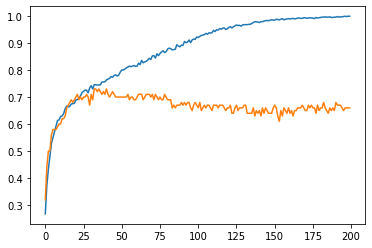

In [ ]:
# Выводим график точности распознования на обучающей и проверочной выборке
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Простая сеть 'elu': один скрытый слой и 10 нейронов.
Точность на обучающей выборке = 73%
Точность на проверочной выборке = 64% 
Есть тенденция к росту точности на графике, можно дообучить.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
45/45 [==============================] - 1s 9ms/step - loss: 2.4536 - accuracy: 0.1511 - val_loss: 2.4091 - val_accuracy: 0.1100
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 2.2924 - accuracy: 0.1833 - val_loss: 2.2580 - val_accuracy: 0.1300
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 2.1630 - accuracy: 0.2433 - val_loss: 2.1295 - val_accuracy: 0.1700
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 2.0565 - accuracy: 0.2867 - val_loss: 2.0298 - val_accuracy: 0.2100
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.9714 - accuracy: 0.3089 - val_loss: 1.9415 - val_accuracy: 0.2300
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 1.9016 - accuracy: 0.3178 - val_loss: 1.8732 - val_accuracy: 0.2700
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 1.8439 - accuracy: 0.3456 - val_loss: 1.8153 - val_accuracy: 0.2600
Epoch 8/200
4

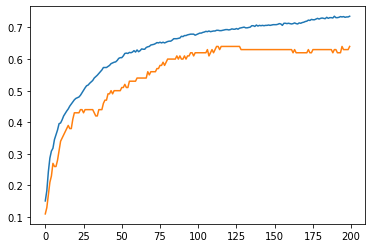

In [ ]:
#Выбираем все виды параметризации
indexes = range(0,37)
#создаем сеть
model_1 = Sequential()
model_1.add(Dense(64, activation='elu', input_shape=(len(indexes),)))
model_1.add(Dense(10, activation='softmax'))
#компилируем
model_1.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем
history = model_1.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Сложная сеть: 5-7 слоёв по 100-1000 нейронов
Точность на обучающей выборке = 10%
Точность на проверочной выборке = 5% 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
45/45 [==============================] - 3s 39ms/step - loss: 2.3027 - accuracy: 0.0867 - val_loss: 2.3027 - val_accuracy: 0.0500
Epoch 2/200
45/45 [==============================] - 1s 31ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3029 - val_accuracy: 0.0800
Epoch 3/200
45/45 [==============================] - 1s 22ms/step - loss: 2.3026 - accuracy: 0.1033 - val_loss: 2.3031 - val_accuracy: 0.0500
Epoch 4/200
45/45 [==============================] - 1s 20ms/step - loss: 2.3026 - accuracy: 0.1056 - val_loss: 2.3032 - val_accuracy: 0.0500
Epoch 5/200
45/45 [==============================] - 1s 19ms/step - loss: 2.3026 - accuracy: 0.1056 - val_loss: 2.3033 - val_accuracy: 0.0500
Epoch 6/200
45/45 [==============================] - 1s 20ms/step - loss: 2.3026 - accuracy: 0.1056 - val_loss: 2.3035 - val_accuracy: 0.0500
Epoch 7/200
45/45 [==============================] - 1s 30ms/step - loss: 2.3026 - accuracy: 0.1056 - val_loss: 2.3036 - val_accuracy: 0.0500
Epoch 

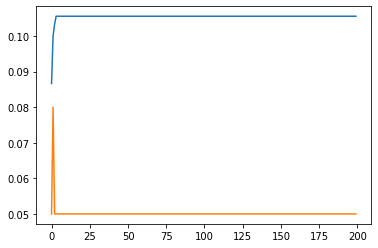

In [ ]:
#Выбираем все виды параметризации
indexes = range(0,37)
#создаем сеть
model_1000 = Sequential()
model_1000.add(Dense(512, activation='elu', input_shape=(len(indexes),)))
model_1000.add(Dense(1024, activation='softmax'))
model_1000.add(Dense(1024, activation='softmax'))
model_1000.add(Dense(256, activation='softmax'))
model_1000.add(Dense(256, activation='softmax'))
model_1000.add(Dense(128, activation='softmax'))
model_1000.add(Dense(128, activation='softmax'))
model_1000.add(Dense(10, activation='softmax'))
#компилируем
model_1000.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем
history = model_1000.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Добавлены в полносвязную сеть слои Dropout
Точность на обучающей выборке = 78%
Точность на проверочной выборке = 67%

Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 2.1454 - accuracy: 0.2244 - val_loss: 1.8747 - val_accuracy: 0.3700
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.9456 - accuracy: 0.2944 - val_loss: 1.7292 - val_accuracy: 0.3600
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.7960 - accuracy: 0.3400 - val_loss: 1.6399 - val_accuracy: 0.4100
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 1.7053 - accuracy: 0.3900 - val_loss: 1.5578 - val_accuracy: 0.4300
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 1.6409 - accuracy: 0.4011 - val_loss: 1.4965 - val_accuracy: 0.4800
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.5812 - accuracy: 0.4389 - val_loss: 1.4424 - val_accuracy: 0.4900
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 1.5680 - accuracy: 0.4444 - val_loss: 1.4021 - val_accuracy: 0.4900
Epoch 8/200
4

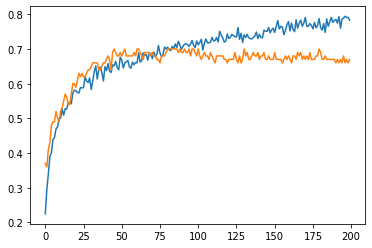

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_D = Sequential()
model_D.add(Dense(256, activation='elu', input_shape = (len(indexes),)))
model_D.add(Dropout(0.2))
model_D.add(Dense(128, activation='elu'))
model_D.add(Dropout(0.2))
model_D.add(Dense(64, activation='elu'))
model_D.add(Dropout(0.2))
model_D.add(Dense(32, activation='elu'))
# model_D.add(Flatten())
model_D.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Добавлены в полносвязную сеть слои BatchNormalization
Точность на обучающей выборке = 95%
Точность на проверочной выборке = 64%

Epoch 1/200
45/45 [==============================] - 2s 7ms/step - loss: 2.3179 - accuracy: 0.2011 - val_loss: 1.9851 - val_accuracy: 0.2900
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.8379 - accuracy: 0.3733 - val_loss: 1.7322 - val_accuracy: 0.4200
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.6204 - accuracy: 0.4667 - val_loss: 1.5642 - val_accuracy: 0.4700
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 1.4955 - accuracy: 0.5067 - val_loss: 1.4384 - val_accuracy: 0.5200
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4111 - accuracy: 0.5344 - val_loss: 1.3519 - val_accuracy: 0.5300
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3377 - accuracy: 0.5644 - val_loss: 1.2833 - val_accuracy: 0.5500
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.2845 - accuracy: 0.5800 - val_loss: 1.2375 - val_accuracy: 0.5500
Epoch 8/200
4

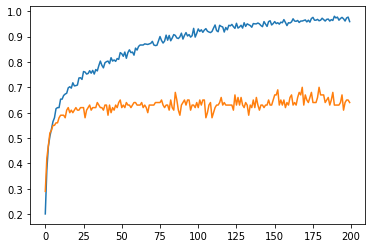

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_B = Sequential()
model_B.add(Dense(256, activation='elu', input_shape = (len(indexes),)))
model_B.add(BatchNormalization())
model_B.add(Dense(128, activation='elu'))
model_B.add(BatchNormalization())
model_B.add(Dense(64, activation='elu'))
model_B.add(BatchNormalization())
model_B.add(Dense(32, activation='elu'))
model_B.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model_B.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_B.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть c 'relu'
Точность на обучающей выборке = 99%
Точность на проверочной выборке = 68%

Epoch 1/200
45/45 [==============================] - 1s 5ms/step - loss: 2.2308 - accuracy: 0.2400 - val_loss: 2.1407 - val_accuracy: 0.3300
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 2.0837 - accuracy: 0.3456 - val_loss: 1.9932 - val_accuracy: 0.3700
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 1.9522 - accuracy: 0.3678 - val_loss: 1.8622 - val_accuracy: 0.3700
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 1.8461 - accuracy: 0.3744 - val_loss: 1.7663 - val_accuracy: 0.3700
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 1.7661 - accuracy: 0.3889 - val_loss: 1.6976 - val_accuracy: 0.4000
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.6991 - accuracy: 0.4056 - val_loss: 1.6408 - val_accuracy: 0.4100
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 1.6380 - accuracy: 0.4200 - val_loss: 1.5812 - val_accuracy: 0.4300
Epoch 8/200
4

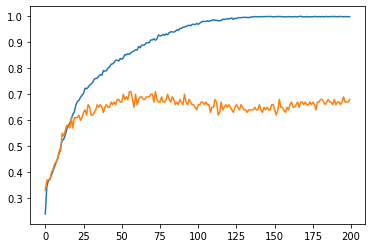

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_relu = Sequential()
model_relu.add(Dense(256, activation='relu', input_shape = (len(indexes),)))
model_relu.add(Dense(128, activation='relu'))
model_relu.add(Dense(64, activation='relu'))
model_relu.add(Dense(32, activation='relu'))
# В конце количество нейронов равно количеству классов и softmax
model_relu.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model_relu.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть c 'linear'
Точность на обучающей выборке = 73%
Точность на проверочной выборке = 60%

Epoch 1/200
45/45 [==============================] - 1s 8ms/step - loss: 1.9600 - accuracy: 0.2667 - val_loss: 1.6275 - val_accuracy: 0.4200
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.6090 - accuracy: 0.3833 - val_loss: 1.4576 - val_accuracy: 0.5000
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 1.4584 - accuracy: 0.4578 - val_loss: 1.3535 - val_accuracy: 0.5400
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3628 - accuracy: 0.5044 - val_loss: 1.2867 - val_accuracy: 0.5500
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 1.2946 - accuracy: 0.5411 - val_loss: 1.2470 - val_accuracy: 0.5900
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.2404 - accuracy: 0.5644 - val_loss: 1.1897 - val_accuracy: 0.6000
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.2036 - accuracy: 0.5867 - val_loss: 1.2033 - val_accuracy: 0.5700
Epoch 8/200
4

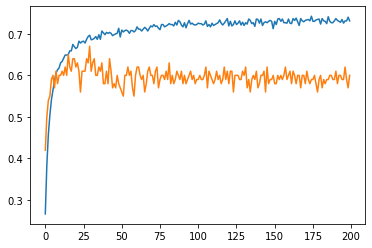

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_linear = Sequential()
model_linear.add(Dense(256, activation='linear', input_shape = (len(indexes),)))
model_linear.add(Dense(128, activation='linear'))
model_linear.add(Dense(64, activation='linear'))
model_linear.add(Dense(32, activation='linear'))
# В конце количество нейронов равно количеству классов и softmax
model_linear.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model_linear.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_linear.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть, batch_size: маленький
Точность на обучающей выборке = 72%
Точность на проверочной выборке = 60%

Epoch 1/200
113/113 [==============================] - 1s 3ms/step - loss: 1.8188 - accuracy: 0.3300 - val_loss: 1.5639 - val_accuracy: 0.4300
Epoch 2/200
113/113 [==============================] - 0s 2ms/step - loss: 1.4705 - accuracy: 0.4733 - val_loss: 1.3749 - val_accuracy: 0.4800
Epoch 3/200
113/113 [==============================] - 0s 2ms/step - loss: 1.3468 - accuracy: 0.5222 - val_loss: 1.2627 - val_accuracy: 0.5900
Epoch 4/200
113/113 [==============================] - 0s 2ms/step - loss: 1.2633 - accuracy: 0.5700 - val_loss: 1.2217 - val_accuracy: 0.5400
Epoch 5/200
113/113 [==============================] - 0s 2ms/step - loss: 1.2072 - accuracy: 0.5922 - val_loss: 1.1371 - val_accuracy: 0.6200
Epoch 6/200
113/113 [==============================] - 0s 2ms/step - loss: 1.1695 - accuracy: 0.6122 - val_loss: 1.1330 - val_accuracy: 0.6100
Epoch 7/200
113/113 [==============================] - 0s 2ms/step - loss: 1.1355 - accuracy: 0.6044 - val_loss: 1.0949 - val_accuracy: 0.6300

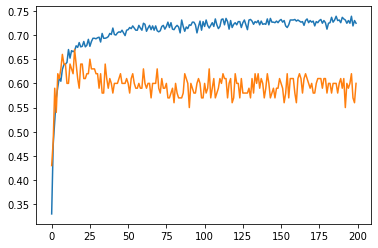

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_bs_s = Sequential()
model_bs_s.add(Dense(256, activation='linear', input_shape = (len(indexes),)))
model_bs_s.add(Dense(128, activation='linear'))
model_bs_s.add(Dense(64, activation='linear'))
model_bs_s.add(Dense(32, activation='linear'))
# В конце количество нейронов равно количеству классов и softmax
model_bs_s.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model_bs_s.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_bs_s.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=8,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть, batch_size: средний
Точность на обучающей выборке = 69%
Точность на проверочной выборке = 61%

Epoch 1/200
8/8 [==============================] - 1s 25ms/step - loss: 2.3820 - accuracy: 0.1500 - val_loss: 2.0797 - val_accuracy: 0.2400
Epoch 2/200
8/8 [==============================] - 0s 6ms/step - loss: 2.0321 - accuracy: 0.2489 - val_loss: 1.8704 - val_accuracy: 0.3400
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 1.8716 - accuracy: 0.3167 - val_loss: 1.7347 - val_accuracy: 0.3600
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 1.7656 - accuracy: 0.3500 - val_loss: 1.6252 - val_accuracy: 0.4100
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 1.6842 - accuracy: 0.3822 - val_loss: 1.5591 - val_accuracy: 0.4400
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 1.6244 - accuracy: 0.4022 - val_loss: 1.5129 - val_accuracy: 0.4700
Epoch 7/200
8/8 [==============================] - 0s 5ms/step - loss: 1.5725 - accuracy: 0.4089 - val_loss: 1.4693 - val_accuracy: 0.4900
Epoch 8/200
8/8 [=========

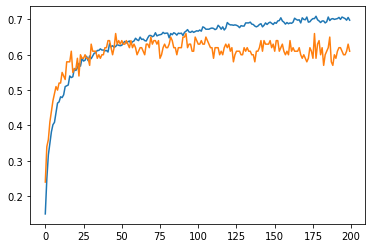

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_bs_m = Sequential()
model_bs_m.add(Dense(256, activation='linear', input_shape = (len(indexes),)))
model_bs_m.add(Dense(128, activation='linear'))
model_bs_m.add(Dense(64, activation='linear'))
model_bs_m.add(Dense(32, activation='linear'))
# В конце количество нейронов равно количеству классов и softmax
model_bs_m.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model_bs_m.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_bs_m.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=128,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть, batch_size: большой
Точность на обучающей выборке = 71%
Точность на проверочной выборке = 57%

Epoch 1/200
4/4 [==============================] - 1s 54ms/step - loss: 2.2510 - accuracy: 0.1956 - val_loss: 1.9386 - val_accuracy: 0.3100
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 1.9929 - accuracy: 0.3111 - val_loss: 1.8190 - val_accuracy: 0.3600
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 1.8719 - accuracy: 0.3378 - val_loss: 1.7416 - val_accuracy: 0.3900
Epoch 4/200
4/4 [==============================] - 0s 10ms/step - loss: 1.7905 - accuracy: 0.3600 - val_loss: 1.6756 - val_accuracy: 0.4100
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 1.7261 - accuracy: 0.3822 - val_loss: 1.6294 - val_accuracy: 0.4400
Epoch 6/200
4/4 [==============================] - 0s 13ms/step - loss: 1.6736 - accuracy: 0.3944 - val_loss: 1.5862 - val_accuracy: 0.4700
Epoch 7/200
4/4 [==============================] - 0s 10ms/step - loss: 1.6263 - accuracy: 0.4189 - val_loss: 1.5485 - val_accuracy: 0.4800
Epoch 8/200
4/4 [===

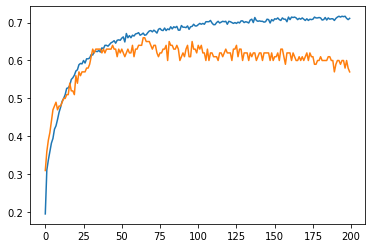

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_bs_l = Sequential()
model_bs_l.add(Dense(256, activation='linear', input_shape = (len(indexes),)))
model_bs_l.add(Dense(128, activation='linear'))
model_bs_l.add(Dense(64, activation='linear'))
model_bs_l.add(Dense(32, activation='linear'))
# В конце количество нейронов равно количеству классов и softmax
model_bs_l.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model_bs_l.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_bs_l.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=256,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Выводы

Лучше всего отработала полносвзная сеть с 'relu' активационной функцией. 
Сложная сеть показада наихудший результат.
Самый оптимальный batch_size - средний.
BatcNormalization слой не оправдал ожиданий , а вот Dropout возможно улучшит результат в комплексе с простой архитектурой сети.
У простой нейронки с одним внутренним слоем хорошая перспектива, можно поработать с гиперпараметрами и добавить Dropout слои , а также средний batch_size и протестировать 2 модели с функциями активации 'relu' и 'elu'. На учебных задачах зачастую хорошо себя проявляют простые модели.